In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
import math
import time
import random
import numpy as np
from collections import deque
from queue import deque
from ChessBoard import ChessBoard

##### 定义超参数

In [3]:
EMPTY = 2
# 超参数
GAMMA = 0.9         # Q衰减系数
INITIAL_E = 0.1     # 初始ε
FINAL_E = 0.001		# 初始ε
REPLAY_SIZE = 10000  # 经验回放大小
BATCH_SIZE = 200  	# 批大小
TAGET_Q_STEP = 100  # 目标网络同步训练次数

##### 定义DQN类

In [4]:
class DQN():
    def __init__(self):
        # 棋盘大小
        self.SIZE = ChessBoard.SIZE
        self.state_dim = self.SIZE * self.SIZE + 1
        self.action_dim = self.SIZE * self.SIZE
        # 其它参数
        self.replay_buffer = deque()
        self.time_step = 0
        self.epsilon = INITIAL_E

        self.hide_layer_inputs = 52

        # 创建网络
        self.create_Q()
        self.create_targetQ()
        self.targetQ_step = TAGET_Q_STEP
        # 定义优化器
        self.train_method()
        # 定义执行器
        gpu_options = tf.GPUOptions(allow_growth=True)
        gpu_options = tf.GPUOptions(
            per_process_gpu_memory_fraction=0.8, allow_growth=True)  # 每个gpu占用0.8的显存
        config = tf.ConfigProto(
            gpu_options=gpu_options, allow_soft_placement=True, log_device_placement=False)
        # 如果电脑有多个GPU，tensorflow默认全部使用。如果想只使用部分GPU，可以设置CUDA_VISIBLE_DEVICES。
        self.sess = tf.Session(config=config)

        # 网络初始化
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)

    def create_Q(self):
        # 网络权值
        W1 = self.weight_variable([self.state_dim, self.hide_layer_inputs])
        b1 = self.bias_variable([self.hide_layer_inputs])
        W2 = self.weight_variable([self.hide_layer_inputs, self.action_dim])
        b2 = self.bias_variable([self.action_dim])
        # 输入层
        self.state_input = tf.placeholder("float", [None, self.state_dim])
        # 隐藏层
        h_layer = tf.nn.relu(tf.matmul(self.state_input, W1) + b1)
        # 输出层
        self.Q_value = tf.matmul(h_layer, W2) + b2
        # 保存权重
        self.Q_weihgts = [W1, b1, W2, b2]

    def create_targetQ(self):
        # network weights
        W1 = self.weight_variable([self.state_dim, self.hide_layer_inputs])
        b1 = self.bias_variable([self.hide_layer_inputs])
        W2 = self.weight_variable([self.hide_layer_inputs, self.action_dim])
        b2 = self.bias_variable([self.action_dim])
        # input layer
        # self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input, W1) + b1)
        # Q Value layer
        self.targetQ_value = tf.matmul(h_layer, W2) + b2
        self.targetQ_weights = [W1, b1, W2, b2]

    def copy(self):
        """拷贝网络"""
        for i in range(len(self.Q_weihgts)):
            self.sess.run(
                tf.assign(self.targetQ_weights[i], self.Q_weihgts[i]))

    def train_method(self):
        self.action_input = tf.placeholder("float", [None, self.action_dim])
        self.y_input = tf.placeholder("float", [None])

        Q_action = tf.reduce_sum(tf.multiply(
            self.Q_value, self.action_input), reduction_indices=1)  # mul->matmul
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.train = tf.train.AdamOptimizer(1e-3).minimize(self.cost)

    def perceive(self, state, action, reward, next_state, done):
        """添加经验池"""
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append(
            [state, one_hot_action, reward, next_state, done])
        # 经验池满了
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()
        # 一个batch够了
        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def modify_last_reward(self, new_reward):
        v = self.replay_buffer.pop()
        v[2] = new_reward
        self.replay_buffer.append(v)

    def train_Q_network(self):
        self.time_step += 1
        # 构建一个小的训练batch
        minibatch = random.sample(self.replay_buffer, BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]
        # 构建训练数据
        y_batch = []

        """
            这里是计算新局面的估值                                                                                                                    Q'
            使用：targetQ 或 Q  网络来计算

            全局就在此处可能使用targetQ，作为对新状态的估值

            在csdn的代码中，使用targetQ的代码被注释掉了
        """
        # 计算Q'的所有值
        # Q_value_batch = self.sess.run(self.Q_value, feed_dict={
        #                               self.state_input: next_state_batch})
        Q_value_batch = self.sess.run(self.targetQ_value, feed_dict={
                                      self.state_input: next_state_batch})

        # Q的值 Q = γ * max(Q')
        for i in range(0, BATCH_SIZE):
            done = minibatch[i][4]  # 是否结束
            if done:
                y_batch.append(reward_batch[i])
            else:
                y_batch.append(reward_batch[i] +
                               GAMMA * np.max(Q_value_batch[i]))
        self.sess.run(self.train, feed_dict={
                      self.y_input: y_batch, self.action_input: action_batch, self.state_input: state_batch})

        # 每一定轮次 拷贝Q网络到targetQ网络
        if self.time_step % self.targetQ_step == 0:
            self.epsilon *= 0.99  # 每次更新targetQ，减小随机选择落子点的概率
            self.copy()

    def egreedy_action(self, state):
        """含有随机 计算一步"""
        # 计算当前局面的所有Q值
        Q_value = self.sess.run(self.Q_value, feed_dict={
                                self.state_input: [state]})[0]

        min_v = Q_value[np.argmin(Q_value)] - 1  # 最小的Q_value -1
        valid_action = []

        for i in range(len(Q_value)):  # 遍历每一个落子点
            if state[i] == EMPTY:  # 空，可以落子
                valid_action.append(i)
            else:  # 有棋子，不可以落子
                Q_value[i] = min_v

        # 以 epsilon的概率随机落子
        if random.random() <= self.epsilon:
            l = len(valid_action)
            if l == 0:
                return -1
            else:
                return valid_action[random.randint(0, len(valid_action) - 1)]
        else:  # 其它清空，选取Q最大的点落子
            return np.argmax(Q_value)

    def action(self, state):
       # 计算当前局面的所有Q值
        Q_value = self.sess.run(self.Q_value, feed_dict={
                                self.state_input: [state]})[0]

        min_v = Q_value[np.argmin(Q_value)] - 1  # 最小的Q_value -1
        valid_action = []

        for i in range(len(Q_value)):  # 遍历每一个落子点
            if state[i] == EMPTY:  # 空，可以落子
                valid_action.append(i)
            else:  # 有棋子，不可以落子
                Q_value[i] = min_v
        return np.argmax(Q_value)

    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.constant(0.01, shape=shape)
        return tf.Variable(initial)


In [5]:
def test():
    total_reward = 0
    # 初始一个棋盘
    chess = ChessBoard()  # 创建一个主棋盘
    chess.reset()
    
    state = chess.board
    camp = -1
    state = np.reshape(state, [-1])
    state = np.append(state, camp)
    
    for j in range(300):
        # 开始走棋
        action = agent.action(state)  # 按照Q网络的走一步
        action = [math.floor(action/ChessBoard.SIZE), action %
                  ChessBoard.SIZE, camp]  # 转化为二维棋盘坐标

        state, reward, done, _ = chess.draw_XY(action[0], action[1])
        if j % 2 == 0:
            camp = 1
        else:
            camp = -1
        state = np.append(state, camp)
        total_reward += reward

        # 打印棋盘
        os.system("cls")
        chess.printChess()
        if camp == 1:
            print(" BLACK %d   %d\n" % (action[0], action[1]))
        else:
            print(" WHITE %d   %d\n" % (action[0], action[1]))
        time.sleep(2)  # 睡眠延时

        # 结束判断
        if done:
            print("done step:%d  episode:%d" % (j, episode))
            # print('done')
            time.sleep(5)
            break
    ave_reward = total_reward
    print('episode: ', episode, 'Evaluation Average Reward:', ave_reward)

In [6]:
train_step = []
agent = DQN()  # 创建网络对象
agent.copy()  # 拷贝Q网络参数到targetQ

In [7]:
def main():
    # 一些超参数
    EPISODE = 50000
    STEP = 300
    TEST = 1

    chess = ChessBoard()  # 创建一个主棋盘

    for episode in range(EPISODE):
        # 初始一个棋盘
        chess.reset()
        state = chess.board
        camp = -1
        state = np.reshape(state, [-1])  # 二维数组转换为一维数组
        state = np.append(state, camp)
        # 训练
        for step in range(STEP):
            # 自己下一步棋
            action_1d = agent.egreedy_action(state)  # 有随机概率的走一步
            action_2d = [math.floor(action_1d / ChessBoard.SIZE), action_1d %
                         ChessBoard.SIZE, camp]  # 转化为二维棋盘坐标
            # 在模拟棋盘上落子
            next_state_2d, reward, done, _ = chess.draw_XY(
                action_2d[0], action_2d[1])
            next_state = np.reshape(next_state_2d, [-1])
            # 构造数据
            if step % 2 == 0:
                camp = 1
            else:
                camp = -1
            next_state = np.append(next_state, camp)
            # 定义奖励
            reward_agent = reward
            agent.perceive(state, action_1d, reward, next_state, done)
            state = next_state
            # 判断这一步走了每    没走说明这一步是非法的，发生了碰撞，立即结束当前棋局，重开一局
            # 上面的判断不是很对
            # 成功落子后反而跳出了
            if done:
                #chess.printChess()
                train_step.append(step)
                print("done step:%d  episode:%d" % (step, episode))
                break

        """单步落子的查看，暂不跑
        if episode % 100 == 99:
            print("\n\nTest block")
            total_reward = 0
            # 测试 TEST盘棋
            for i in range(TEST):
                # 初始一个棋盘
                chess.reset()
                state = chess.board
                camp = -1
                state = np.reshape(state, [-1])
                state = np.append(state, camp)
                for j in range(STEP):
                    # 开始走棋
                    action = agent.action(state)  # 按照Q网络的走一步
                    action = [math.floor(action/ChessBoard.SIZE), action %
                              ChessBoard.SIZE, camp]  # 转化为二维棋盘坐标

                    state, reward, done, _ = chess.draw_XY(
                        action[0], action[1])
                    if j % 2 == 0:
                        camp = 1
                    else:
                        camp = -1
                    state = np.append(state, camp)
                    total_reward += reward

                    # 打印棋盘
                    os.system("cls")
                    chess.printChess()
                    if camp == 1:
                        print("\n BLACK %d   %d" % (action[0], action[1]))
                    else:
                        print("\n WHITE %d   %d" % (action[0], action[1]))
                    time.sleep(2)  # 睡眠延时

                    # 结束判断
                    if done:
                        print("done step:%d  episode:%d" % (j, episode))
                        # print('done')
                        time.sleep(5)
                        break

            ave_reward = total_reward / TEST
            print('episode: ', episode, 'Evaluation Average Reward:', ave_reward)
        """

##### 开始训练

In [10]:
main()

done step:52  episode:0
done step:40  episode:1
done step:53  episode:2
done step:41  episode:3
done step:47  episode:4
done step:33  episode:5
done step:52  episode:6
done step:35  episode:7
done step:47  episode:8
done step:41  episode:9
done step:32  episode:10
done step:35  episode:11
done step:33  episode:12
done step:12  episode:13
done step:10  episode:14
done step:43  episode:15
done step:24  episode:16
done step:10  episode:17
done step:48  episode:18
done step:40  episode:19
done step:23  episode:20
done step:65  episode:21
done step:25  episode:22
done step:22  episode:23
done step:30  episode:24
done step:44  episode:25
done step:22  episode:26
done step:46  episode:27
done step:50  episode:28
done step:41  episode:29
done step:40  episode:30
done step:32  episode:31
done step:33  episode:32
done step:42  episode:33
done step:37  episode:34
done step:23  episode:35
done step:30  episode:36
done step:31  episode:37
done step:22  episode:38
done step:41  episode:39
done step:

done step:43  episode:321
done step:143  episode:322
done step:44  episode:323
done step:29  episode:324
done step:54  episode:325
done step:36  episode:326
done step:43  episode:327
done step:76  episode:328
done step:25  episode:329
done step:161  episode:330
done step:45  episode:331
done step:35  episode:332
done step:27  episode:333
done step:36  episode:334
done step:99  episode:335
done step:34  episode:336
done step:35  episode:337
done step:45  episode:338
done step:46  episode:339
done step:32  episode:340
done step:42  episode:341
done step:27  episode:342
done step:76  episode:343
done step:36  episode:344
done step:45  episode:345
done step:43  episode:346
done step:34  episode:347
done step:28  episode:348
done step:41  episode:349
done step:39  episode:350
done step:44  episode:351
done step:27  episode:352
done step:47  episode:353
done step:33  episode:354
done step:33  episode:355
done step:32  episode:356
done step:41  episode:357
done step:48  episode:358
done step:

done step:26  episode:637
done step:22  episode:638
done step:27  episode:639
done step:31  episode:640
done step:41  episode:641
done step:35  episode:642
done step:22  episode:643
done step:169  episode:644
done step:21  episode:645
done step:31  episode:646
done step:34  episode:647
done step:44  episode:648
done step:31  episode:649
done step:43  episode:650
done step:28  episode:651
done step:35  episode:652
done step:35  episode:653
done step:31  episode:654
done step:28  episode:655
done step:43  episode:656
done step:40  episode:657
done step:29  episode:658
done step:45  episode:659
done step:43  episode:660
done step:31  episode:661
done step:38  episode:662
done step:29  episode:663
done step:41  episode:664
done step:68  episode:665
done step:39  episode:666
done step:39  episode:667
done step:45  episode:668
done step:43  episode:669
done step:43  episode:670
done step:42  episode:671
done step:30  episode:672
done step:26  episode:673
done step:42  episode:674
done step:4

done step:32  episode:959
done step:43  episode:960
done step:43  episode:961
done step:38  episode:962
done step:15  episode:963
done step:39  episode:964
done step:34  episode:965
done step:35  episode:966
done step:13  episode:968
done step:26  episode:969
done step:15  episode:970
done step:17  episode:971
done step:13  episode:972
done step:13  episode:973
done step:19  episode:974
done step:15  episode:975
done step:19  episode:976
done step:15  episode:978
done step:15  episode:979
done step:15  episode:980
done step:15  episode:981
done step:15  episode:982
done step:15  episode:983
done step:15  episode:984
done step:17  episode:985
done step:15  episode:986
done step:15  episode:987
done step:15  episode:988
done step:15  episode:989
done step:13  episode:990
done step:15  episode:991
done step:15  episode:992
done step:15  episode:993
done step:13  episode:994
done step:15  episode:995
done step:15  episode:996
done step:17  episode:997
done step:15  episode:998
done step:15

done step:35  episode:1270
done step:37  episode:1271
done step:35  episode:1273
done step:21  episode:1274
done step:23  episode:1275
done step:21  episode:1276
done step:21  episode:1277
done step:21  episode:1278
done step:29  episode:1279
done step:21  episode:1280
done step:42  episode:1282
done step:49  episode:1283
done step:32  episode:1284
done step:39  episode:1286
done step:31  episode:1287
done step:23  episode:1288
done step:47  episode:1289
done step:27  episode:1290
done step:25  episode:1291
done step:29  episode:1292
done step:244  episode:1293
done step:23  episode:1294
done step:29  episode:1295
done step:31  episode:1296
done step:33  episode:1297
done step:25  episode:1298
done step:23  episode:1299
done step:29  episode:1300
done step:32  episode:1301
done step:33  episode:1302
done step:43  episode:1303
done step:23  episode:1304
done step:29  episode:1305
done step:25  episode:1306
done step:29  episode:1307
done step:43  episode:1308
done step:40  episode:1309


done step:44  episode:1589
done step:34  episode:1590
done step:34  episode:1591
done step:19  episode:1592
done step:30  episode:1593
done step:41  episode:1594
done step:37  episode:1595
done step:27  episode:1596
done step:27  episode:1597
done step:41  episode:1598
done step:26  episode:1600
done step:30  episode:1601
done step:38  episode:1602
done step:41  episode:1603
done step:46  episode:1604
done step:43  episode:1605
done step:44  episode:1606
done step:42  episode:1607
done step:49  episode:1608
done step:32  episode:1609
done step:41  episode:1610
done step:39  episode:1611
done step:34  episode:1612
done step:45  episode:1613
done step:18  episode:1614
done step:36  episode:1615
done step:48  episode:1616
done step:37  episode:1617
done step:37  episode:1618
done step:39  episode:1619
done step:31  episode:1621
done step:42  episode:1622
done step:35  episode:1623
done step:35  episode:1625
done step:31  episode:1626
done step:26  episode:1627
done step:35  episode:1628
d

KeyboardInterrupt: 

In [11]:
print(len(train_step))
test()

1921
    0  1  2  3  4  5  6
 0  -  -  *  -  -  -  -
 1  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -
 3  -  -  -  -  -  -  -
 4  -  -  -  -  -  -  -
 5  -  -  -  -  -  -  -
 6  -  -  -  -  -  -  -
 BLACK 0   2

    0  1  2  3  4  5  6
 0  -  -  *  -  -  -  -
 1  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -
 3  -  -  -  o  -  -  -
 4  -  -  -  -  -  -  -
 5  -  -  -  -  -  -  -
 6  -  -  -  -  -  -  -
 WHITE 3   3

    0  1  2  3  4  5  6
 0  -  -  *  -  -  -  -
 1  -  -  *  -  -  -  -
 2  -  -  -  -  -  -  -
 3  -  -  -  o  -  -  -
 4  -  -  -  -  -  -  -
 5  -  -  -  -  -  -  -
 6  -  -  -  -  -  -  -
 BLACK 1   2

    0  1  2  3  4  5  6
 0  -  -  *  -  -  -  -
 1  -  -  *  -  -  -  -
 2  -  -  -  -  -  -  -
 3  -  o  -  o  -  -  -
 4  -  -  -  -  -  -  -
 5  -  -  -  -  -  -  -
 6  -  -  -  -  -  -  -
 WHITE 3   1

    0  1  2  3  4  5  6
 0  -  -  *  -  -  -  -
 1  -  -  *  -  -  -  -
 2  -  -  -  -  -  -  -
 3  -  o  -  o  -  -  -
 4  *  -  -  -  -  -  -
 5  -  -  -  -  -  -  -
 6 

KeyboardInterrupt: 

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

<function matplotlib.pyplot.show(*args, **kw)>

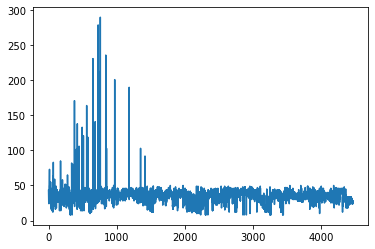

In [35]:
plt.plot(train_step)
plt.savefig("C:/Users/王欣哲/Desktop/codes/人工智能基础/问题4 监督学习/step.jpg")
plt.show